In [1]:
import os
import re
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from khmernltk import word_tokenize
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
# from khmerphonemizer import phonemize

In [5]:
output_path = '../dataset'
print(output_path)

../dataset


### Load Dataset

In [3]:
df = pd.read_csv(f"{output_path}/line_index.tsv", sep='\t', names=["filename", "original_text"], index_col=1)
df.head()

,filename,original_text
NaN,khm_0308_0011865648,ស្ពាន កំពង់ ចម្លង អ្នកលឿង នៅ ព្រៃវែង ជា ស្ពាន ...
NaN,khm_0308_0032157149,ភ្លើង កំពុង ឆាប ឆេះ ផ្ទះ ប្រជា ពលរដ្ឋ នៅ សង្កា...
NaN,khm_0308_0038959268,អ្នក សុំ ទាន ដេក ប្រកាច់ ម្នាក់ ឯង ក្បែរ ខ្លោង...
NaN,khm_0308_0054635313,ស្ករ ត្នោត ដែល មាន គុណភាព ល្អ ផលិត នៅ ខេត្ត កំ...
NaN,khm_0308_0055735195,ភ្នំបាខែង មាន កម្ពស់ តែ ចិត សិប ម៉ែត្រ សោះ


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2906 entries, nan to nan
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   filename       2906 non-null   object
 1   original_text  2906 non-null   object
dtypes: object(2)
memory usage: 68.1+ KB


## 1. Dataset Overview

In [5]:
total_duration = 0
total_text_length = 0

# Calculate audio duration and text length
for line_index, transcription in zip(df['filename'], df['original_text']):
    wav_path = os.path.join(output_path, 'wavs', f'{line_index}.wav')
    
    if os.path.exists(wav_path):
        y, sr = librosa.load(wav_path, sr=None)
        duration = librosa.get_duration(y=y, sr=sr)
        total_duration += duration
        total_text_length += len(transcription)
    else:
        print(f'File not found: {wav_path}')

# Print Statistics
total_duration_hours = total_duration / 3600
print(f'Total duration: {total_duration_hours} hours')
print(f'Total text length: {total_text_length} characters')

Total duration: 3.9667806481481387 hours
Total text length: 146460 characters


### 1.2 Distribution Analysis

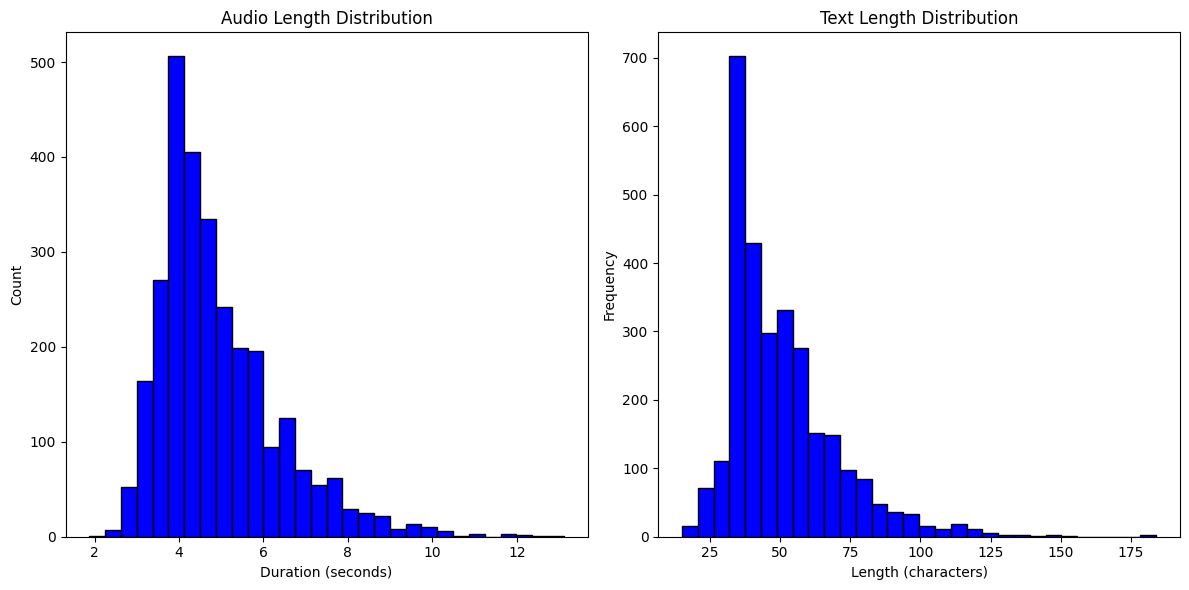

In [6]:
audio_lengths = []
text_lengths = []

for line_index, transcription in zip(df['filename'], df['original_text']): 
    wav_path = os.path.join(output_path, 'wavs', f'{line_index}.wav')
    y, sr = librosa.load(wav_path, sr=None)
    audio_lengths.append(librosa.get_duration(y=y, sr=sr))
    text_lengths.append(len(transcription))

# Plot historgram
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(audio_lengths, bins=30, color='blue', edgecolor='black', align= 'mid')
plt.title('Audio Length Distribution')
plt.xlabel('Duration (seconds)')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.hist(text_lengths, bins=30, color='blue', edgecolor='black', align= 'mid')
plt.title('Text Length Distribution')
plt.xlabel('Length (characters)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

### 1.3 Quality Check

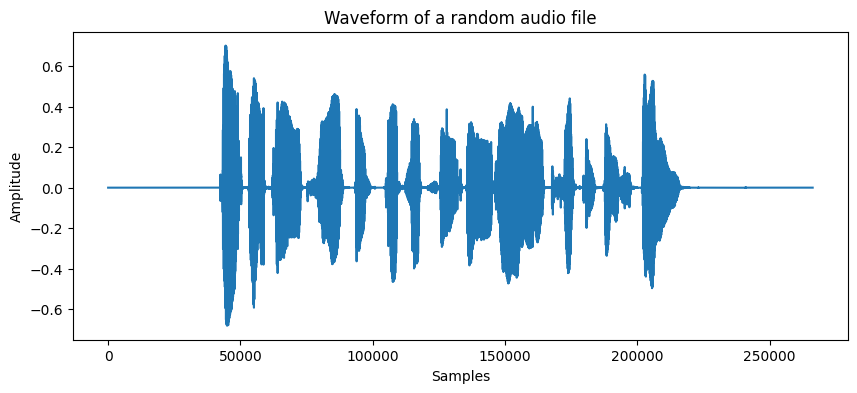

In [7]:
# Visualize a random audio file
random_file = os.path.join(output_path, 'wavs', df.sample(1)['filename'].values[0] + '.wav')
y, sr = librosa.load(random_file, sr=None)
plt.figure(figsize=(10, 4))
plt.plot(y)
plt.title('Waveform of a random audio file')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.show()

# Listen to the audio file if running locally
import IPython.display as ipd
ipd.Audio(random_file)

### 1.4 Identify Outliers

In [8]:
# Identify outliers
short_audio = df[[length < 1 for length in audio_lengths]] # Audio files less than 1 second
long_audio = df[[length > 10 for length in audio_lengths]] # Audio files more than 10 seconds

print(f"Short audio files: {short_audio}") # All Dataset audio are longer than 1 second
print(f"Long audio files: {long_audio}") 

# Overview
# - We found 17 audio files that are longer than 10 seconds which considered as outliers
# - Fortunately, there are no audio which are shorter than 1 second

Short audio files: Empty DataFrame
Columns: [filename, original_text]
Index: []
Long audio files:                 filename                                      original_text
NaN  khm_0877_0872623068  មន្ត្រី អគ្គិសនី កម្ពុជា បាន ចាប់ផ្តើម ចុះ ត ប...
NaN  khm_0877_1541265349  ចំការ ស្នេហ៍ បាន បើក ដំណើរការ ឱ្យ ភ្ញៀវ ជាតិ អ...
NaN  khm_0877_4223828546  ភ្ញៀវ ទេសចរ ជាតិ និង អន្ដរជាតិ អញ្ជើញ មក លំហែ ...
NaN  khm_0995_0986867544  អាស៊ាន អាយធី កុំព្យូទ័រ មាន បម្រើ សេវាកម្ម ដូច...
NaN  khm_0995_2939576555  ស្ដេច អាប់ឌុលឡា របស់ ហ្សកដានី យាង ជួប សម្ដែង ក...
NaN  khm_1161_2022197355  ប្រទេស ជប៉ុន បាន រៀបចំ ពិធី បើក សម្ពោធ ផលិតផល ...
NaN  khm_1161_2224475179  លោក តាំង សុធារិទ្ធ តំណាង ឱ្យ ក្រុមហ៊ុន ស៊ុនស៊ី...
NaN  khm_1161_2835582962  មជ្ឈមណ្ឌល ថែ រក្សា សម្ផស្ស មេហ្គាប៊ែល ជា ផ្នែក...
NaN  khm_1728_2082523788  នៅ ថ្ងៃ ពុធ នេះ ក្រោម អធិបតីភាព របស់ ព្រះ ចៅអធ...
NaN  khm_2499_1359902572  ឥណ្ឌូនេស៊ី ជា ប្រទេស ស្ថាបនិក និង ដឹកនាំ រដ្ឋា...
NaN  khm_4119_2528871695  លោក ត្រូវ បាន អាជ្ញាធរ មាន សមត្ថកិច្ច ចា

In [9]:
# # Removing Outliers
# for line_index in long_audio['line_index']:
#     wav_path = os.path.join(output_path, 'wavs', f'{line_index}.wav')
#     os.remove(wav_path)

# # Remove outliers from the dataset
# transcriptions = df[~df['line_index'].isin(long_audio['line_index'])]

# # Check dataset size
# print(f'Number of samples after removing outliers: {len(transcriptions)}')

### 1.5 Correlation Heatmap of Acoustic Features

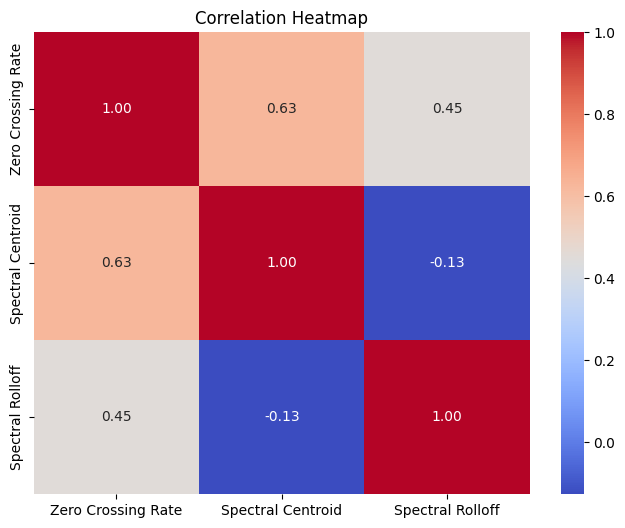

In [10]:
features = {
  "Zero Crossing Rate": [],
  "Spectral Centroid": [],
  "Spectral Rolloff": [],
}

for line_index in df['filename']:
    wav_path = os.path.join(output_path, 'wavs', f'{line_index}.wav')
    y, sr = librosa.load(wav_path, sr=None)
    
    # Zero Crossing Rate
    zcr = librosa.feature.zero_crossing_rate(y)
    features["Zero Crossing Rate"].append(np.mean(zcr))
    
    # Spectral Centroid
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    features["Spectral Centroid"].append(np.mean(spectral_centroid))
    
    # Spectral Rolloff
    spectral_rolloff = librosa.feature.spectral_rolloff(y=y+0.01, sr=sr)[0]
    features["Spectral Rolloff"].append(np.mean(spectral_rolloff))

# Add features to the dataframe
features_df = pd.DataFrame(features)

# Plot Correlation Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(features_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

### 1.6 Pitch Distribution

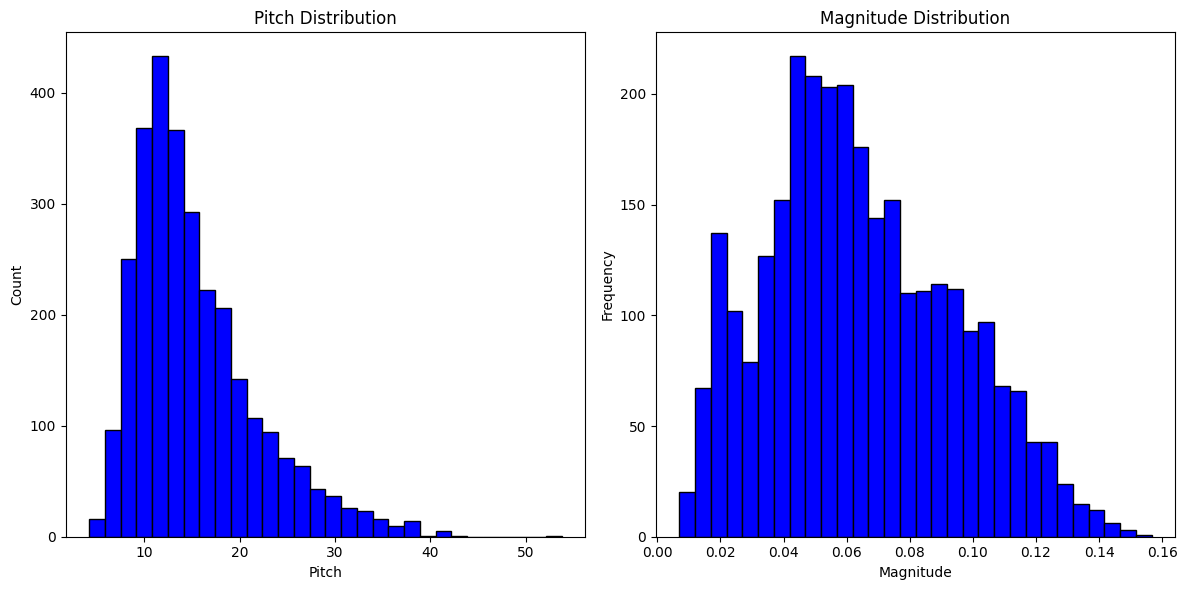

In [11]:
pitches = []
magnitudes = []

for line_index in df['filename']:
    wav_path = os.path.join(output_path, 'wavs', f'{line_index}.wav')
    y, sr = librosa.load(wav_path, sr=None)
    
    # Extract pitch and magnitude
    pitches_, magnitudes_ = librosa.piptrack(y=y, sr=sr)
    pitches.append(np.mean(pitches_))
    magnitudes.append(np.mean(magnitudes_))

# Add features to the dataframe
features_df['Pitch'] = pitches
features_df['Magnitude'] = magnitudes

# Plot Pitch and Magnitude distribution
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(pitches, bins=30, color='blue', edgecolor='black', align= 'mid')
plt.title('Pitch Distribution')
plt.xlabel('Pitch')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.hist(magnitudes, bins=30, color='blue', edgecolor='black', align= 'mid')
plt.title('Magnitude Distribution')
plt.xlabel('Magnitude')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

### 1.7 Boxplot for Duration

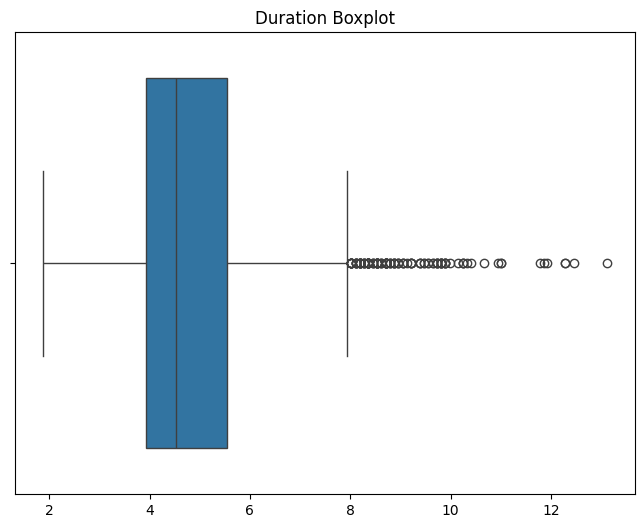

In [12]:
# Boxplot for Duration
plt.figure(figsize=(8, 6))
sns.boxplot(x=audio_lengths)
plt.title('Duration Boxplot')
plt.show()

### 1.8 WordCloud for Tokens

| 2025-01-09 19:33:31,834 | INFO | khmer-nltk | Loaded model from f:\Anaconda\envs\khmer-tts\Lib\site-packages\khmernltk\word_tokenize\sklearn_crf_ner_10000.sav |


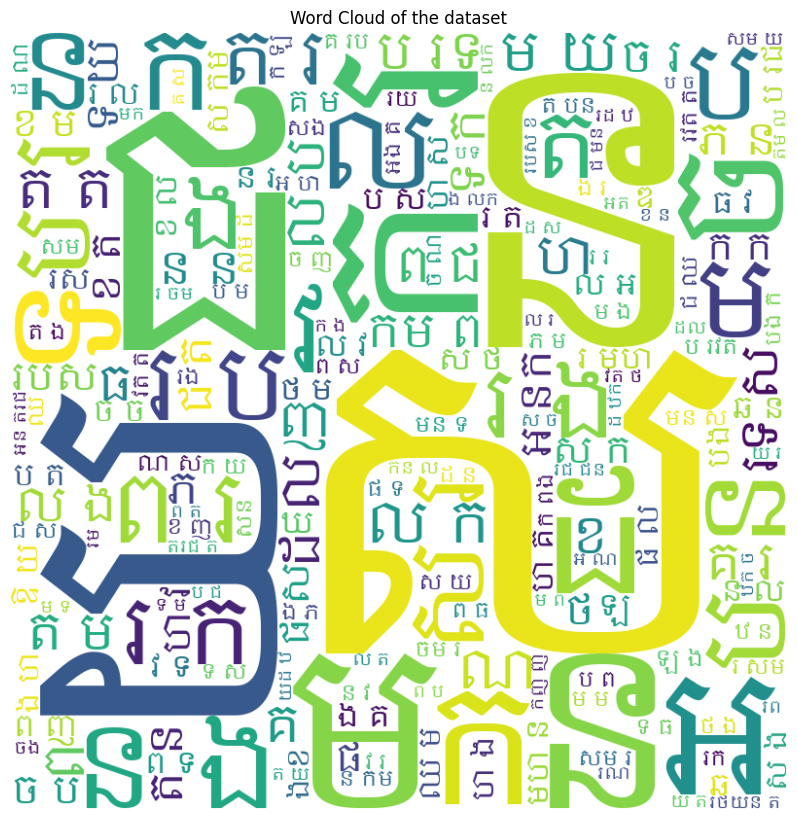

In [13]:
from wordcloud import WordCloud

# Tokenize text
df["tokenized_text"] = df["original_text"].apply(word_tokenize)

# Combine all tokens into a single list
all_tokens = [token for tokens in df['tokenized_text'] for token in tokens]

# Join toekns into a single string for WordCloud generation
text_for_wordcloud = ' '.join(all_tokens)

# Generate word cloud
wordcloud = WordCloud(
    width = 800, height = 800, 
    background_color ='white', 
    colormap='viridis',
    font_path='KhmerOS.ttf',
).generate(text_for_wordcloud)

# Plot word cloud
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title('Word Cloud of the dataset')
plt.tight_layout(pad=0)
plt.show()

## 2. Data Processing

### 2.1 Data Normalization

In [14]:
def normalize_text(text):
    # Remove unwanted punctuation
    text = re.sub(r'[!?]', '', text)
    # Replace multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text)
    # Trim leading/trailing spaces
    text = text.strip()
    return text

# Example usage
text = "  អា  ហារ!  "
normalized_text = normalize_text(text)
print(normalized_text)

អា ហារ


In [15]:
df["tokenized_text"] = df["original_text"].apply(word_tokenize)
df.head()

,filename,original_text,tokenized_text
NaN,khm_0308_0011865648,ស្ពាន កំពង់ ចម្លង អ្នកលឿង នៅ ព្រៃវែង ជា ស្ពាន ...,"[ស្ពាន, , កំពង់, , ចម្លង, , អ្នកលឿង, , នៅ,..."
NaN,khm_0308_0032157149,ភ្លើង កំពុង ឆាប ឆេះ ផ្ទះ ប្រជា ពលរដ្ឋ នៅ សង្កា...,"[ភ្លើង, , កំពុង, , ឆាប, , ឆេះ, , ផ្ទះ, , ..."
NaN,khm_0308_0038959268,អ្នក សុំ ទាន ដេក ប្រកាច់ ម្នាក់ ឯង ក្បែរ ខ្លោង...,"[អ្នក, , សុំ, , ទាន, , ដេក, , ប្រកាច់, , ..."
NaN,khm_0308_0054635313,ស្ករ ត្នោត ដែល មាន គុណភាព ល្អ ផលិត នៅ ខេត្ត កំ...,"[ស្ករ, , ត្នោត, , ដែល, , មាន, , គុណភាព, ,..."
NaN,khm_0308_0055735195,ភ្នំបាខែង មាន កម្ពស់ តែ ចិត សិប ម៉ែត្រ សោះ,"[ភ្នំ, បាខែង, , មាន, , កម្ពស់, , តែ, , ចិត..."


In [16]:
# Filter empty tokens
df["tokenized_text"] = df["tokenized_text"].apply(
    lambda tokens: [token for token in tokens if token.strip() != '']
)
df.head()

,filename,original_text,tokenized_text
NaN,khm_0308_0011865648,ស្ពាន កំពង់ ចម្លង អ្នកលឿង នៅ ព្រៃវែង ជា ស្ពាន ...,"[ស្ពាន, កំពង់, ចម្លង, អ្នកលឿង, នៅ, ព្រៃវែង, ជា..."
NaN,khm_0308_0032157149,ភ្លើង កំពុង ឆាប ឆេះ ផ្ទះ ប្រជា ពលរដ្ឋ នៅ សង្កា...,"[ភ្លើង, កំពុង, ឆាប, ឆេះ, ផ្ទះ, ប្រជា, ពលរដ្ឋ, ..."
NaN,khm_0308_0038959268,អ្នក សុំ ទាន ដេក ប្រកាច់ ម្នាក់ ឯង ក្បែរ ខ្លោង...,"[អ្នក, សុំ, ទាន, ដេក, ប្រកាច់, ម្នាក់, ឯង, ក្ប..."
NaN,khm_0308_0054635313,ស្ករ ត្នោត ដែល មាន គុណភាព ល្អ ផលិត នៅ ខេត្ត កំ...,"[ស្ករ, ត្នោត, ដែល, មាន, គុណភាព, ល្អ, ផលិត, នៅ,..."
NaN,khm_0308_0055735195,ភ្នំបាខែង មាន កម្ពស់ តែ ចិត សិប ម៉ែត្រ សោះ,"[ភ្នំ, បាខែង, មាន, កម្ពស់, តែ, ចិត, សិប, ម៉ែត្..."


In [17]:
def grapheme_tokenize(tokens):
    # Tokenize each token (word) into graphemes (characters)
    return [list(token) for token in tokens]

df["grapheme_tokenized"] = df["tokenized_text"].apply(grapheme_tokenize)
df.head()

,filename,original_text,tokenized_text,grapheme_tokenized
NaN,khm_0308_0011865648,ស្ពាន កំពង់ ចម្លង អ្នកលឿង នៅ ព្រៃវែង ជា ស្ពាន ...,"[ស្ពាន, កំពង់, ចម្លង, អ្នកលឿង, នៅ, ព្រៃវែង, ជា...","[[ស, ្, ព, ា, ន], [ក, ំ, ព, ង, ់], [ច, ម, ្, ល..."
NaN,khm_0308_0032157149,ភ្លើង កំពុង ឆាប ឆេះ ផ្ទះ ប្រជា ពលរដ្ឋ នៅ សង្កា...,"[ភ្លើង, កំពុង, ឆាប, ឆេះ, ផ្ទះ, ប្រជា, ពលរដ្ឋ, ...","[[ភ, ្, ល, ើ, ង], [ក, ំ, ព, ុ, ង], [ឆ, ា, ប], ..."
NaN,khm_0308_0038959268,អ្នក សុំ ទាន ដេក ប្រកាច់ ម្នាក់ ឯង ក្បែរ ខ្លោង...,"[អ្នក, សុំ, ទាន, ដេក, ប្រកាច់, ម្នាក់, ឯង, ក្ប...","[[អ, ្, ន, ក], [ស, ុ, ំ], [ទ, ា, ន], [ដ, េ, ក]..."
NaN,khm_0308_0054635313,ស្ករ ត្នោត ដែល មាន គុណភាព ល្អ ផលិត នៅ ខេត្ត កំ...,"[ស្ករ, ត្នោត, ដែល, មាន, គុណភាព, ល្អ, ផលិត, នៅ,...","[[ស, ្, ក, រ], [ត, ្, ន, ោ, ត], [ដ, ែ, ល], [ម,..."
NaN,khm_0308_0055735195,ភ្នំបាខែង មាន កម្ពស់ តែ ចិត សិប ម៉ែត្រ សោះ,"[ភ្នំ, បាខែង, មាន, កម្ពស់, តែ, ចិត, សិប, ម៉ែត្...","[[ភ, ្, ន, ំ], [ប, ា, ខ, ែ, ង], [ម, ា, ន], [ក,..."


In [18]:
# Add special tokens
special_tokens = ["<UNK>", "<PAD>", "<SOS>", "<EOS>"]
vocab = {token: idx for idx, token in enumerate(special_tokens)}

# Build vocabulary for graphemes
# Flatten the list of lists to a single list of graphemes
all_graphemes = set(grapheme for word_list in df["grapheme_tokenized"] for word in word_list for grapheme in word)

# Add graphemes to the vocabulary
vocab.update({grapheme: idx + len(vocab) for idx, grapheme in enumerate(sorted(all_graphemes))})
print(vocab)

# Save the vocabulary (optional)
with open(f"{output_path}/tacotron2_grapheme_vocab.txt", "w+") as f:
    f.write(str(vocab))

{'<UNK>': 0, '<PAD>': 1, '<SOS>': 2, '<EOS>': 3, 'ក': 4, 'ខ': 5, 'គ': 6, 'ឃ': 7, 'ង': 8, 'ច': 9, 'ឆ': 10, 'ជ': 11, 'ឈ': 12, 'ញ': 13, 'ដ': 14, 'ឋ': 15, 'ឌ': 16, 'ឍ': 17, 'ណ': 18, 'ត': 19, 'ថ': 20, 'ទ': 21, 'ធ': 22, 'ន': 23, 'ប': 24, 'ផ': 25, 'ព': 26, 'ភ': 27, 'ម': 28, 'យ': 29, 'រ': 30, 'ល': 31, 'វ': 32, 'ស': 33, 'ហ': 34, 'ឡ': 35, 'អ': 36, 'ឥ': 37, 'ឧ': 38, 'ឪ': 39, 'ឫ': 40, 'ឬ': 41, 'ឭ': 42, 'ឮ': 43, 'ឯ': 44, 'ឱ': 45, 'ា': 46, 'ិ': 47, 'ី': 48, 'ឹ': 49, 'ឺ': 50, 'ុ': 51, 'ូ': 52, 'ួ': 53, 'ើ': 54, 'ឿ': 55, 'ៀ': 56, 'េ': 57, 'ែ': 58, 'ៃ': 59, 'ោ': 60, 'ៅ': 61, 'ំ': 62, 'ះ': 63, 'ៈ': 64, '៉': 65, '៊': 66, '់': 67, '៌': 68, '៍': 69, '៎': 70, '៏': 71, '័': 72, '្': 73}


In [19]:
# Encode grapheme-tokenized text
# Encode each grapheme in the list of lists using the vocabulary
df["encoded_grapheme_text"] = df["grapheme_tokenized"].apply(
    lambda word_list: [[vocab.get(grapheme, vocab["<UNK>"]) for grapheme in word] for word in word_list]
)

df.head()

,filename,original_text,tokenized_text,grapheme_tokenized,encoded_grapheme_text
NaN,khm_0308_0011865648,ស្ពាន កំពង់ ចម្លង អ្នកលឿង នៅ ព្រៃវែង ជា ស្ពាន ...,"[ស្ពាន, កំពង់, ចម្លង, អ្នកលឿង, នៅ, ព្រៃវែង, ជា...","[[ស, ្, ព, ា, ន], [ក, ំ, ព, ង, ់], [ច, ម, ្, ល...","[[33, 73, 26, 46, 23], [4, 62, 26, 8, 67], [9,..."
NaN,khm_0308_0032157149,ភ្លើង កំពុង ឆាប ឆេះ ផ្ទះ ប្រជា ពលរដ្ឋ នៅ សង្កា...,"[ភ្លើង, កំពុង, ឆាប, ឆេះ, ផ្ទះ, ប្រជា, ពលរដ្ឋ, ...","[[ភ, ្, ល, ើ, ង], [ក, ំ, ព, ុ, ង], [ឆ, ា, ប], ...","[[27, 73, 31, 54, 8], [4, 62, 26, 51, 8], [10,..."
NaN,khm_0308_0038959268,អ្នក សុំ ទាន ដេក ប្រកាច់ ម្នាក់ ឯង ក្បែរ ខ្លោង...,"[អ្នក, សុំ, ទាន, ដេក, ប្រកាច់, ម្នាក់, ឯង, ក្ប...","[[អ, ្, ន, ក], [ស, ុ, ំ], [ទ, ា, ន], [ដ, េ, ក]...","[[36, 73, 23, 4], [33, 51, 62], [21, 46, 23], ..."
NaN,khm_0308_0054635313,ស្ករ ត្នោត ដែល មាន គុណភាព ល្អ ផលិត នៅ ខេត្ត កំ...,"[ស្ករ, ត្នោត, ដែល, មាន, គុណភាព, ល្អ, ផលិត, នៅ,...","[[ស, ្, ក, រ], [ត, ្, ន, ោ, ត], [ដ, ែ, ល], [ម,...","[[33, 73, 4, 30], [19, 73, 23, 60, 19], [14, 5..."
NaN,khm_0308_0055735195,ភ្នំបាខែង មាន កម្ពស់ តែ ចិត សិប ម៉ែត្រ សោះ,"[ភ្នំ, បាខែង, មាន, កម្ពស់, តែ, ចិត, សិប, ម៉ែត្...","[[ភ, ្, ន, ំ], [ប, ា, ខ, ែ, ង], [ម, ា, ន], [ក,...","[[27, 73, 23, 62], [24, 46, 5, 58, 8], [28, 46..."


In [ ]:
# Define a function to phonemize each token
def phonemize_tokens(tokens):
    # Phonemize each word in the tokenized text
    phonemized_words = [phonemize(word)[1][0] for word in tokens]  # Extract the phoneme list
    return phonemized_words

# Apply phonemization to each row
df["phoneme_tokenized"] = df["tokenized_text"].apply(phonemize_tokens)
df.head()

In [33]:
# Add special tokens
special_tokens = ["<UNK>", "<PAD>", "<SOS>", "<EOS>"]
phoneme_vocab = {token: idx for idx, token in enumerate(special_tokens)}

# Build vocabulary for phonemes
# Flatten the list of lists to a single list of phonemes
all_phonemes = set(phoneme for word_list in df["phoneme_tokenized"] for word in word_list for phoneme in word)

# Add phonemes to the vocabulary
phoneme_vocab.update({phoneme: idx + len(phoneme_vocab) for idx, phoneme in enumerate(sorted(all_phonemes))})
print(phoneme_vocab)

# Save the vocabulary (optional)
with open(f"{output_path}/tacotron2_phoneme_vocab.txt", "w+") as f:
    f.write(str(phoneme_vocab))

{'<UNK>': 0, '<PAD>': 1, '<SOS>': 2, '<EOS>': 3, 'a': 4, 'aː': 5, 'c': 6, 'cʰ': 7, 'e': 8, 'eː': 9, 'f': 10, 'h': 11, 'i': 12, 'iː': 13, 'j': 14, 'k': 15, 'kʰ': 16, 'l': 17, 'm': 18, 'n': 19, 'o': 20, 'oː': 21, 'p': 22, 'pʰ': 23, 'r': 24, 's': 25, 't': 26, 'tʰ': 27, 'u': 28, 'uː': 29, 'w': 30, 'z': 31, 'ĕ': 32, 'ŋ': 33, 'ŏ': 34, 'ŭ': 35, 'ɑ': 36, 'ɑː': 37, 'ɓ': 38, 'ɔ': 39, 'ɔː': 40, 'ɗ': 41, 'ə': 42, 'əː': 43, 'ɛː': 44, 'ɡ': 45, 'ɨ': 46, 'ɨː': 47, 'ɲ': 48, 'ʋ': 49, 'ʔ': 50}


In [35]:
# Encode phoneme-tokenized text
# Encode each phoneme in the list of lists using the vocabulary
df["encoded_phoneme_text"] = df["phoneme_tokenized"].apply(
    lambda word_list: [[phoneme_vocab.get(phoneme, phoneme_vocab["<UNK>"]) for phoneme in word] for word in word_list]
)

df.head()

,filename,original_text,tokenized_text,grapheme_tokenized,encoded_grapheme_text,phonemized_token,phoneme_tokenized,encoded_phoneme_text
NaN,khm_0308_0011865648,ស្ពាន កំពង់ ចម្លង អ្នកលឿង នៅ ព្រៃវែង ជា ស្ពាន ...,"[ស្ពាន, កំពង់, ចម្លង, អ្នកលឿង, នៅ, ព្រៃវែង, ជា...","[[ស, ្, ព, ា, ន], [ក, ំ, ព, ង, ់], [ច, ម, ្, ល...","[[33, 73, 26, 46, 23], [4, 62, 26, 8, 67], [9,...","([ស្ពាន, , កំពង់, , ចម្លង, , អ្នកលឿង, , នៅ...","[[s, p, i, ə, n], [k, ɑ, m, p, ŭ, ə, ŋ], [c, ɑ...","[[25, 22, 12, 42, 19], [15, 36, 18, 22, 35, 42..."
NaN,khm_0308_0032157149,ភ្លើង កំពុង ឆាប ឆេះ ផ្ទះ ប្រជា ពលរដ្ឋ នៅ សង្កា...,"[ភ្លើង, កំពុង, ឆាប, ឆេះ, ផ្ទះ, ប្រជា, ពលរដ្ឋ, ...","[[ភ, ្, ល, ើ, ង], [ក, ំ, ព, ុ, ង], [ឆ, ា, ប], ...","[[27, 73, 31, 54, 8], [4, 62, 26, 51, 8], [10,...","([ភ្លើង, , កំពុង, , ឆាប, , ឆេះ, , ផ្ទះ, ,...","[[pʰ, l, əː, ŋ], [k, ɑ, m, p, u, ŋ], [cʰ, aː, ...","[[23, 17, 43, 33], [15, 36, 18, 22, 28, 33], [..."
NaN,khm_0308_0038959268,អ្នក សុំ ទាន ដេក ប្រកាច់ ម្នាក់ ឯង ក្បែរ ខ្លោង...,"[អ្នក, សុំ, ទាន, ដេក, ប្រកាច់, ម្នាក់, ឯង, ក្ប...","[[អ, ្, ន, ក], [ស, ុ, ំ], [ទ, ា, ន], [ដ, េ, ក]...","[[36, 73, 23, 4], [33, 51, 62], [21, 46, 23], ...","([អ្នក, , សុំ, , ទាន, , ដេក, , ប្រកាច់, ,...","[[n, ĕ, ə, ʔ], [s, o, m], [t, i, ə, n], [ɗ, e,...","[[19, 32, 42, 50], [25, 20, 18], [26, 12, 42, ..."
NaN,khm_0308_0054635313,ស្ករ ត្នោត ដែល មាន គុណភាព ល្អ ផលិត នៅ ខេត្ត កំ...,"[ស្ករ, ត្នោត, ដែល, មាន, គុណភាព, ល្អ, ផលិត, នៅ,...","[[ស, ្, ក, រ], [ត, ្, ន, ោ, ត], [ដ, ែ, ល], [ម,...","[[33, 73, 4, 30], [19, 73, 23, 60, 19], [14, 5...","([ស្ករ, , ត្នោត, , ដែល, , មាន, , គុណភាព, ...","[[s, k, ɑː], [tʰ, n, a, o, t], [ɗ, a, e, l], [...","[[25, 15, 37], [27, 19, 4, 20, 26], [41, 4, 8,..."
NaN,khm_0308_0055735195,ភ្នំបាខែង មាន កម្ពស់ តែ ចិត សិប ម៉ែត្រ សោះ,"[ភ្នំ, បាខែង, មាន, កម្ពស់, តែ, ចិត, សិប, ម៉ែត្...","[[ភ, ្, ន, ំ], [ប, ា, ខ, ែ, ង], [ម, ា, ន], [ក,...","[[27, 73, 23, 62], [24, 46, 5, 58, 8], [28, 46...","([ភ្នំ, បាខែង, , មាន, , កម្ពស់, , តែ, , ចិ...","[[pʰ, n, u, m], [ɓ, aː], [m, i, ə, n], [k, ɑ, ...","[[23, 19, 28, 18], [38, 5], [18, 12, 42, 19], ..."


### 2.2 Audio Extraction

In [21]:
def process_audio_files(input_dir, output_dir):
    for index, row in df.iterrows():
        audio_path = os.path.join(input_dir, f"{row['filename']}.wav")
        output_path = os.path.join(output_dir, f"{row['filename']}_mel.npy")

        # Load and process audio
        waveform, sample_rate = librosa.load(audio_path, sr=22050)
        waveform = waveform / max(abs(waveform))  # Normalize
        waveform, _ = librosa.effects.trim(waveform)  # Trim silence

        # Compute Mel spectrogram
        mel_spectrogram = librosa.feature.melspectrogram(
            y=waveform, sr=sample_rate, n_fft=1024, hop_length=256, n_mels=80
        )
        mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

        # Save as .npy
        np.save(output_path, mel_spectrogram_db)

    print("Audio processing completed!")

# Example usage
# process_audio_files(f"{output_path}/wavs/", f"{output_path}/processed_wavs/")

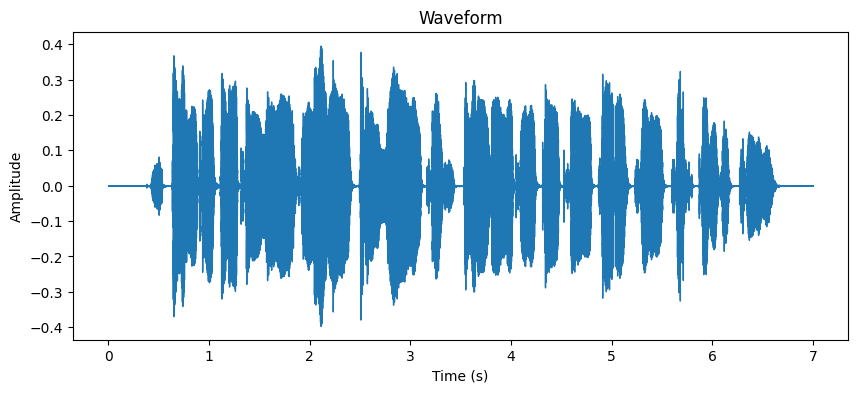

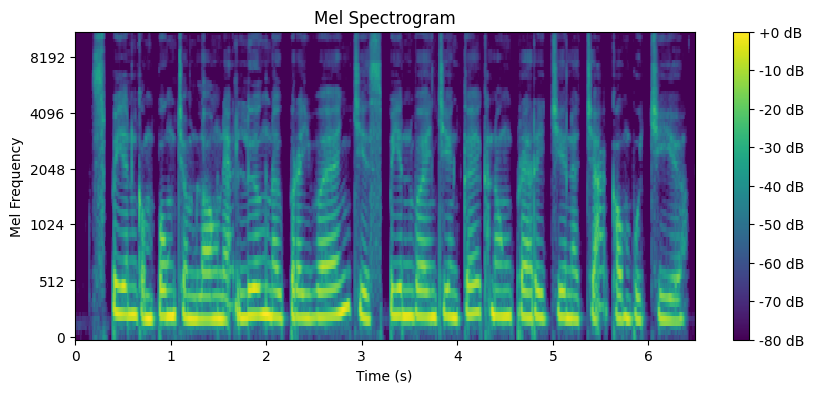

In [22]:
# Validate mel spectrogram
# Load the original waveform
audio_path = f"{output_path}/wavs/khm_0308_0011865648.wav"
waveform, sr = librosa.load(audio_path, sr=22050)

# Load the Mel spectrogram
mel_path = f"{output_path}/processed_wavs/khm_0308_0011865648_mel.npy"
mel_spectrogram = np.load(mel_path)

# Plot the waveform
plt.figure(figsize=(10, 4))
plt.title("Waveform")
librosa.display.waveshow(waveform, sr=sr)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

# Plot the Mel spectrogram
plt.figure(figsize=(10, 4))
plt.title("Mel Spectrogram")
librosa.display.specshow(mel_spectrogram, sr=sr, hop_length=256, x_axis='time', y_axis='mel', cmap='viridis')
plt.colorbar(format="%+2.0f dB")
plt.xlabel("Time (s)")
plt.ylabel("Mel Frequency")
plt.show()

In [23]:
# Include the mel spectrogram path
df["mel_path"] = df["filename"].apply(lambda x: f"processed_wavs/{x.split('.')[0]}_mel.npy")
df.head()

,filename,original_text,tokenized_text,grapheme_tokenized,encoded_grapheme_text,mel_path
NaN,khm_0308_0011865648,ស្ពាន កំពង់ ចម្លង អ្នកលឿង នៅ ព្រៃវែង ជា ស្ពាន ...,"[ស្ពាន, កំពង់, ចម្លង, អ្នកលឿង, នៅ, ព្រៃវែង, ជា...","[[ស, ្, ព, ា, ន], [ក, ំ, ព, ង, ់], [ច, ម, ្, ល...","[[33, 73, 26, 46, 23], [4, 62, 26, 8, 67], [9,...",processed_wavs/khm_0308_0011865648_mel.npy
NaN,khm_0308_0032157149,ភ្លើង កំពុង ឆាប ឆេះ ផ្ទះ ប្រជា ពលរដ្ឋ នៅ សង្កា...,"[ភ្លើង, កំពុង, ឆាប, ឆេះ, ផ្ទះ, ប្រជា, ពលរដ្ឋ, ...","[[ភ, ្, ល, ើ, ង], [ក, ំ, ព, ុ, ង], [ឆ, ា, ប], ...","[[27, 73, 31, 54, 8], [4, 62, 26, 51, 8], [10,...",processed_wavs/khm_0308_0032157149_mel.npy
NaN,khm_0308_0038959268,អ្នក សុំ ទាន ដេក ប្រកាច់ ម្នាក់ ឯង ក្បែរ ខ្លោង...,"[អ្នក, សុំ, ទាន, ដេក, ប្រកាច់, ម្នាក់, ឯង, ក្ប...","[[អ, ្, ន, ក], [ស, ុ, ំ], [ទ, ា, ន], [ដ, េ, ក]...","[[36, 73, 23, 4], [33, 51, 62], [21, 46, 23], ...",processed_wavs/khm_0308_0038959268_mel.npy
NaN,khm_0308_0054635313,ស្ករ ត្នោត ដែល មាន គុណភាព ល្អ ផលិត នៅ ខេត្ត កំ...,"[ស្ករ, ត្នោត, ដែល, មាន, គុណភាព, ល្អ, ផលិត, នៅ,...","[[ស, ្, ក, រ], [ត, ្, ន, ោ, ត], [ដ, ែ, ល], [ម,...","[[33, 73, 4, 30], [19, 73, 23, 60, 19], [14, 5...",processed_wavs/khm_0308_0054635313_mel.npy
NaN,khm_0308_0055735195,ភ្នំបាខែង មាន កម្ពស់ តែ ចិត សិប ម៉ែត្រ សោះ,"[ភ្នំ, បាខែង, មាន, កម្ពស់, តែ, ចិត, សិប, ម៉ែត្...","[[ភ, ្, ន, ំ], [ប, ា, ខ, ែ, ង], [ម, ា, ន], [ក,...","[[27, 73, 23, 62], [24, 46, 5, 58, 8], [28, 46...",processed_wavs/khm_0308_0055735195_mel.npy


In [24]:
# Print a single row of the dataframe - full information
print(df.iloc[0])

filename                                               khm_0308_0011865648
original_text            ស្ពាន កំពង់ ចម្លង អ្នកលឿង នៅ ព្រៃវែង ជា ស្ពាន ...
tokenized_text           [ស្ពាន, កំពង់, ចម្លង, អ្នកលឿង, នៅ, ព្រៃវែង, ជា...
grapheme_tokenized       [[ស, ្, ព, ា, ន], [ក, ំ, ព, ង, ់], [ច, ម, ្, ល...
encoded_grapheme_text    [[33, 73, 26, 46, 23], [4, 62, 26, 8, 67], [9,...
mel_path                        processed_wavs/khm_0308_0011865648_mel.npy
Name: nan, dtype: object
